## Import

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import itertools
from sklearn.model_selection import StratifiedKFold

## Utils

In [23]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history.
    This function takes a history object returned by the `model.fit()` method 
    and plots the training and validation loss and accuracy over the epochs.
    
    Parameters:
    - history (dict): A dictionary containing the training history. It should 
      have the following keys:
        - 'loss': List of training loss values.
        - 'val_loss': List of validation loss values.
        - 'accuracy': List of training accuracy values.
        - 'val_accuracy': List of validation accuracy values.
    """
    
    # Extract data from history
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history["val_accuracy"]
    
    epochs = range(1, len(train_loss) + 1)  # Number of epochs

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()


In [24]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    :param param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).
    :return: List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination into a dictionary with hyperparameter names as keys
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

In [25]:
def create_hidden_layers(hidden_size, num_layers):
    """
    Create a tuple to configure hidden_layer_sizes based on the number of layers and the size of each layer.
    
    Parameters:
    - hidden_size (int): Number of units for each hidden layer.
    - num_layers (int): Number of hidden layers.
    
    Returns:
    - tuple: Configuration for hidden_layer_sizes.
    """
    # Check if the number of layers is at least 1
    if num_layers <= 0:
        raise ValueError("The number of hidden layers must be at least 1.")
    
    # Check if the size of each hidden layer is greater than 0
    if hidden_size <= 0:
        raise ValueError("The size of hidden layers must be greater than 0.")
    
    # Create a tuple with the specified number of layers, each having the specified size
    return tuple([hidden_size] * num_layers)

## Data load

In [26]:
# One-hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)

# Load the training and test files for each dataset from the specified path
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)

# List to store the transformed datasets
monks_train = []
monks_test = []

# Dataset monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Features
y1_train = monk1_train.iloc[:, 0].values    # Labels

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Apply the encoder to monk1
X1_train_encoded = encoder.fit_transform(X1_train)  # Fit and transform on training data
X1_test_encoded = encoder.transform(X1_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X1_train_encoded, y1_train))
monks_test.append((X1_test_encoded, y1_test))

# Dataset monk2
X2_train = monk2_train.iloc[:, 1:7].values  # Features
y2_train = monk2_train.iloc[:, 0].values    # Labels

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Apply the encoder to monk2
X2_train_encoded = encoder.fit_transform(X2_train)  # Fit and transform on training data
X2_test_encoded = encoder.transform(X2_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X2_train_encoded, y2_train))
monks_test.append((X2_test_encoded, y2_test))

# Dataset monk3
X3_train = monk3_train.iloc[:, 1:7].values  # Features
y3_train = monk3_train.iloc[:, 0].values    # Labels

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

# Apply the encoder to monk3
X3_train_encoded = encoder.fit_transform(X3_train)  # Fit and transform on training data
X3_test_encoded = encoder.transform(X3_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X3_train_encoded, y3_train))
monks_test.append((X3_test_encoded, y3_test))

## Model creation

In [27]:
def create_nn(activ_type = 'tanh', optim_type = 'sgd', reg_flag = False, learning_rate=0.01, hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, batch_size = 4, epochs = 50):
    """
        Create a neural network model using scikit-learn's MLPClassifier.
        Parameters:
        activ_type (str): Activation function for the hidden layer. Default is 'tanh'.
                          Options include 'identity', 'logistic', 'tanh', 'relu'.
        optim_type (str): The solver for weight optimization. Default is 'sgd'.
                          Options include 'lbfgs', 'sgd', 'adam'.
        reg_flag (bool): If True, apply L2 regularization. Default is False.
        learning_rate (float): Initial learning rate. Default is 0.01.
        hidden_size (int): Number of neurons in each hidden layer. Default is 6.
        hidden_layers (int): Number of hidden layers. Default is 1.
        regularization (float): L2 penalty (regularization term) parameter. Default is 0.01.
        momentum (float): Momentum for gradient descent update. Default is 0.9.
        batch_size (int): Size of minibatches for stochastic optimizers. Default is 4.
        epochs (int): Maximum number of iterations. Default is 50.
        Returns:
        model (MLPClassifier): Configured MLPClassifier model.
        """

    # Create a tuple representing the hidden layer sizes based on the specified number of layers and size
    tuple_hidden_layers = create_hidden_layers(hidden_size, hidden_layers)

    # Check if regularization is enabled
    if reg_flag:
        # Create an MLPClassifier model with L2 regularization
        model = MLPClassifier(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=regularization, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size=batch_size, random_state=42)
    else:
        # Create an MLPClassifier model without L2 regularization
        model = MLPClassifier(hidden_layer_sizes=tuple_hidden_layers, activation=activ_type,
                    solver=optim_type, alpha=0, learning_rate_init=learning_rate, 
                    learning_rate='adaptive', momentum=momentum, nesterovs_momentum=True, max_iter=epochs,
                    warm_start=False, batch_size=batch_size, random_state=42)

    # Return the configured MLPClassifier model
    return model

In [28]:
def fit(model: MLPClassifier, X_train, y_train, X_test, y_test, epochs=100, batch_size=1, patience=5):
    """
    Train the model using manual epochs and early stopping.

    Parameters:
    - model (MLPClassifier): The neural network model to be trained.
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Validation data features.
    - y_test (array-like): Validation data labels.
    - epochs (int): Number of epochs to train the model.
    - batch_size (int): Size of the batches for training.
    - patience (int): Number of epochs with no improvement after which training will be stopped.

    Returns:
    - best_model (MLPClassifier): The best model based on validation accuracy.
    - history (dict): A dictionary containing the training history.
    """

    # Initialize history dictionary to store loss and accuracy for each epoch
    history = {
        "loss": [],
        "val_loss": [],
        "accuracy": [],
        "val_accuracy": []
    }

    best_val_acc = -np.inf  # Initialize the best validation accuracy
    best_model = None  # Initialize the best model
    epochs_without_improvement = 0  # Counter for epochs without improvement

    # Manual training loop for the specified number of epochs
    for epoch in range(epochs):
        # Shuffle the training data at the beginning of each epoch
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        # Perform a partial fit on the shuffled training data
        model.partial_fit(X_train, y_train, classes=np.array([0, 1]))
        
        # Record training loss and accuracy
        history["loss"].append(model.loss_)
        history["accuracy"].append(accuracy_score(y_train, model.predict(X_train)))
        
        # Calculate validation accuracy
        val_acc = accuracy_score(y_test, model.predict(X_test))
        history["val_accuracy"].append(val_acc)

        # Calculate validation loss manually
        val_loss = np.mean((model.predict_proba(X_test) - np.eye(len(np.unique(y_test)))[y_test])**2)
        history["val_loss"].append(val_loss)

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc  # Update the best validation accuracy
            best_model = model  # Save the best model
            epochs_without_improvement = 0  # Reset the counter
        else:
            epochs_without_improvement += 1  # Increment the counter

        # Stop training if the model does not improve for `patience` consecutive epochs
        if epochs_without_improvement >= patience:
            break

    return best_model, history

## Double k-fold cross validation

In [29]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 6, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implements Double K-Fold Cross-Validation

    Parameters
    ---------
     -   data (np.ndarray): Features of the dataset.
     -   labels (np.ndarray): Labels of the dataset.
     -   activ_type (str): Activation function type.
     -   optim_type (str): Optimizer type.
     -   reg_flag (bool): Regularization flag.
     -  in_size (int): Input size.
     -   outer_k (int): Number of folds for outer cross-validation.
     -   inner_k (int): Number of folds for inner cross-validation.
     -   param_grid (list): List of dictionaries with hyperparameters to try.
    
    Returns:
    ----------
     -   list: List of scores obtained for each outer fold.
     -   list: List of best parameters for each outer fold.
    """
    outer_scores = []
    outer_params = []
    
    # Configuration of the outer k-fold cross-validation
    out_kfold = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)

    # Outer cross-validation loop
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the outer fold
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        # Iterate over each set of hyperparameters in the parameter grid
        for params in param_grid:

            inner_scores = []

            # Inner cross-validation loop
            inner_fold_no = 1
            inner_kfold = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Split the dataset into training and validation sets for the inner fold
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Create the neural network model with the specified hyperparameters
                model = create_nn(activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'],
                          batch_size=params["batch_size"],
                          epochs=params["epochs"])

                # Train the model with early stopping
                model, history = fit(model, inner_X_train, inner_y_train,
                             inner_X_val, inner_y_val,
                             epochs=params['epochs'],
                             batch_size=params['batch_size'],
                             patience=params['patience'])
                    
                # Append the maximum validation accuracy to inner scores
                inner_scores.append(max(history['val_accuracy']))
                inner_fold_no += 1
            
            # Calculate the average score for the current set of hyperparameters
            avg_score = np.mean(inner_scores)

            # Update the best score and parameters if the current average score is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        
        # Create the neural network model with the specified hyperparameters
        final_model = create_nn(activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=best_params['learning_rate'], 
                          hidden_size=best_params['hidden_size'], 
                          hidden_layers=best_params['hidden_layers'], 
                          regularization=best_params['regularization'], 
                          momentum=best_params['momentum'],
                          batch_size=best_params["batch_size"],
                          epochs=best_params["epochs"])
    
        # Train the model with early stopping
        model, history = fit(final_model, out_X_train, out_y_train,
                             out_X_val, out_y_val,
                             epochs=best_params['epochs'],
                             batch_size=best_params['batch_size'],
                             patience=best_params['patience'])

        # Append the maximum validation accuracy to outer scores
        outer_scores.append(max(history['val_accuracy']))
        outer_params.append(best_params)
        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [30]:
def k_fold_cross_validation(data, labels, activ_type='tanh', optim_type='sgd', reg_flag=False, params=None):
    """
    Perform k-fold cross-validation on the given dataset and return the average validation accuracy,
    training history, and the final trained model.

    Parameters:
    - data (array-like): The input features.
    - labels (array-like): The target labels.
    - activ_type (str): Activation function for the hidden layer. Default is 'tanh'.
    - optim_type (str): The solver for weight optimization. Default is 'sgd'.
    - reg_flag (bool): If True, apply L2 regularization. Default is False.
    - params (dict): Dictionary containing hyperparameters for the neural network.

    Returns:
    - avg_score (float): The average validation accuracy across all folds.
    - history (dict): A dictionary containing the training history of the final model.
    - model (MLPClassifier): The final trained model.
    """
    
    # Configure k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize variables to store fold number and accuracy per fold
    fold_no = 1
    accuracy_per_fold = []

    # Cross-validation loop
    for train_index, val_index in kfold.split(data, labels):
        
        # Split the dataset into training and validation sets
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Create the neural network model with the specified hyperparameters
        model = create_nn(activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'],
                          batch_size=params["batch_size"],
                          epochs=params["epochs"])

        # Train the model with early stopping
        model, history = fit(model, X_train, y_train,
                             X_val, y_val,
                             epochs=params['epochs'],
                             batch_size=params['batch_size'],
                             patience=params['patience'])

        # Get the best validation accuracy from the training history
        score = max(history['val_accuracy'])
        accuracy_per_fold.append(score)    
        fold_no += 1

    # Calculate the average validation accuracy across all folds
    avg_score = np.mean(accuracy_per_fold)

    # Split the dataset into training and validation sets for the final model
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Create the neural network model with the specified hyperparameters
    model = create_nn(activ_type=activ_type,
                      optim_type=optim_type,
                      reg_flag=reg_flag,
                      learning_rate=params['learning_rate'], 
                      hidden_size=params['hidden_size'], 
                      hidden_layers=params['hidden_layers'], 
                      regularization=params['regularization'], 
                      momentum=params['momentum'],
                      batch_size=params["batch_size"],
                      epochs=params["epochs"])

    # Train the final model with early stopping
    model, history = fit(model, X_train, y_train,
                         X_val, y_val,
                         epochs=params['epochs'],
                         batch_size=params['batch_size'],
                         patience=params['patience'])

    return avg_score, history, model

## Greedy search

In [31]:
def greed_search(data, labels, activ_type='tanh', optim_type='sgd', reg_flag=False, param_grid=None):
    """
    Perform a greedy search over the hyperparameter grid to find the best model configurations.

    Parameters:
    - data (array-like): The input features.
    - labels (array-like): The target labels.
    - activ_type (str): Activation function for the hidden layer. Default is 'tanh'.
    - optim_type (str): The solver for weight optimization. Default is 'sgd'.
    - reg_flag (bool): If True, apply L2 regularization. Default is False.
    - param_grid (list): List of dictionaries containing hyperparameters for the neural network.

    Returns:
    - best_scores (list): List of the best validation scores.
    - best_params_list (list): List of the best hyperparameter configurations.
    - best_models (list): List of the best trained models.
    - best_histories (list): List of the training histories of the best models.
    """
    
    best_scores = []  # List to store the best validation scores
    best_params_list = []  # List to store the best hyperparameter configurations
    best_models = []  # List to store the best trained models
    best_histories = []  # List to store the training histories of the best models

    # Iterate over each set of hyperparameters in the grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        
        # Perform k-fold cross-validation with the current set of hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, params=params)
        print(f"Score : {score}")

        # Append the results to the respective lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in descending order and keep only the top 10
        sorted_indices = np.argsort(best_scores)[::-1]  # Sort scores in descending order
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Keep the top 10 scores
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]  # Keep the top 10 parameter sets
        best_models = [best_models[i] for i in sorted_indices][:10]  # Keep the top 10 models
        best_histories = [best_histories[i] for i in sorted_indices][:10]  # Keep the top 10 histories

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 results
    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [32]:
# Initialize lists to store the best scores, parameters, models, and training histories for each dataset
best_scores = [[], [], []]  # Use a list of three elements to store the scores for each dataset
best_params_list = [[], [], []]  # List of three elements to store the best hyperparameter configurations for each dataset
best_models = [[], [], []]  # List of three elements to store the best models for each dataset
best_histories = [[], [], []]  # List of three elements to store the training histories for each dataset

# Select 100 random elements from the parameter grid without replacement
# This line is commented out because it is used in privious fase of greedy search
# np.random.choice(param_grid, size=100, replace=False)

--------------------------------------------------MONK 1--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 340, 'batch_size': 64, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.001, 'patience': 30}
Score : 0.9836666666666666
--------------------END GREED SEARCH------------------------------
--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.4, 'epochs': 340, 'batch_size': 64, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.001, 'patience': 30}
Score: 0.9836666666666666


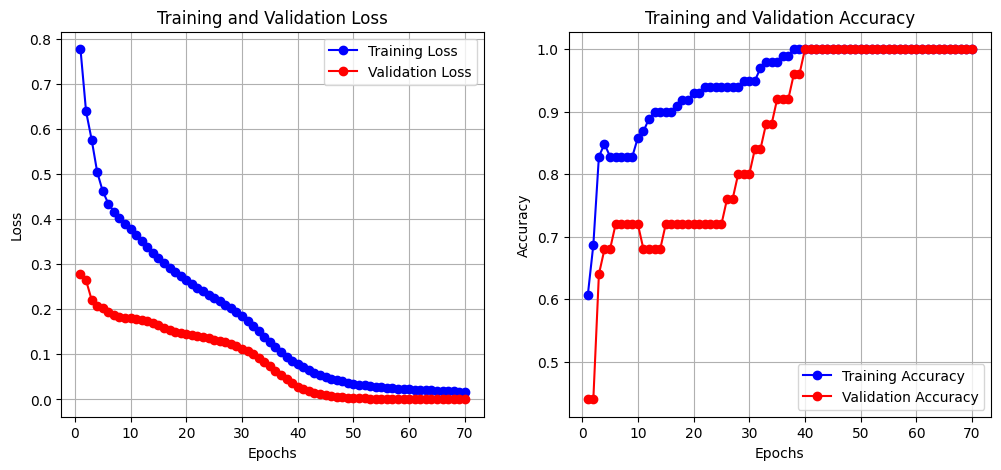

In [33]:
# Define the range of hyperparameters
param_ranges_1 = {
    "learning_rate": (0.4, 0.4, 0.1),  # From 0.1 to 0.4 with a step of 0.1
    "epochs": (340, 340, 1),           # Fixed at 340 epochs
    "batch_size": (64, 64, 1),        # From 16 to 64 with a step of 16
    "hidden_size": (3, 3, 1),          # Fixed at 3 hidden units
    "hidden_layers": (1, 1, 1),        # Fixed at 1 hidden layer
    "momentum": (0.8, 0.8, 0.1),       # From 0.1 to 0.9 with a step of 0.1
    "regularization": (0.001, 0.001, 0.005),  # Fixed at 0.001 regularization
    "patience": (30, 30, 1)            # Fixed at 30 epochs for early stopping patience
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)

print("--------------------------------------------------MONK 1--------------------------------------------------")

# Perform greedy search to find the best hyperparameters for the MONK 1 dataset
best_scores[0], best_params_list[0], best_models[0], best_histories[0] = greed_search(
    X1_train_encoded, y1_train,  # Training data and labels for MONK 1
    'tanh', 'sgd', False,        # Activation function, optimizer, and regularization flag
    param_grid_monk1             # Hyperparameter grid
)

print("--------------------------------------------------Plots--------------------------------------------------")

# Plot the training history for each of the best models found
for i, (history, params, score) in enumerate(zip(best_histories[0], best_params_list[0], best_scores[0])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the validation score
    plot_training_history(history)  # Plot the training and validation loss and accuracy

--------------------------------------------------MONK 2--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.9, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'patience': 30}
Score : 1.0
--------------------END GREED SEARCH------------------------------
--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.9, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'patience': 30}
Score: 1.0


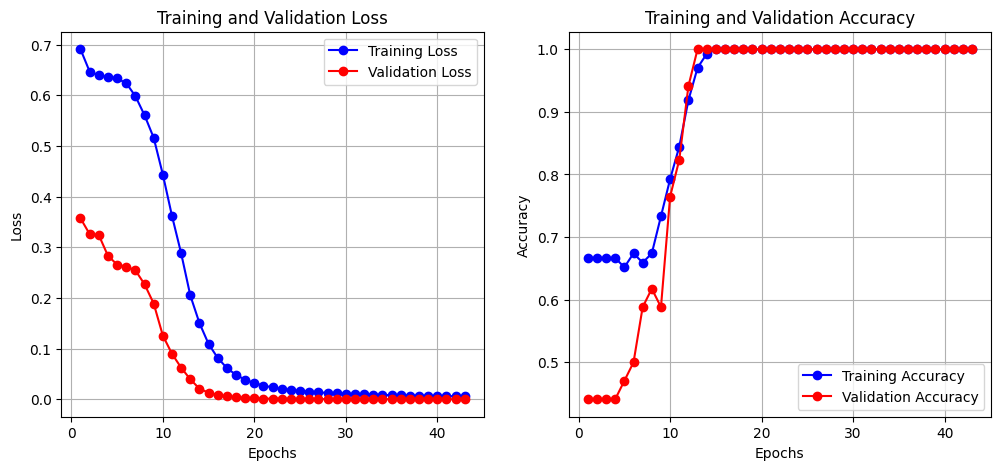

In [34]:
# Define the range of hyperparameters for the MONK 2 dataset
param_ranges_2 = {
    "learning_rate": (0.9, 0.9, 0.1),  # From 0.4 to 0.9 with a step of 0.1
    "epochs": (180, 180, 1),           # Fixed at 180 epochs
    "batch_size": (16, 16, 1),          # From 4 to 16 with a step of 6
    "hidden_size": (3, 3, 1),          # Fixed at 3 hidden units
    "hidden_layers": (1, 1, 1),        # Fixed at 1 hidden layer
    "momentum": (0.6, 0.6, 0.1),       # From 0.3 to 0.6 with a step of 0.1
    "regularization": (0.001, 0.001, 0.005),  # Fixed at 0.001 regularization
    "patience": (30, 30, 1)            # Fixed at 30 epochs for early stopping patience
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk2 = generate_hyperparameter_combinations(param_ranges_2)

print("--------------------------------------------------MONK 2--------------------------------------------------")

# Perform greedy search to find the best hyperparameters for the MONK 2 dataset
best_scores[1], best_params_list[1], best_models[1], best_histories[1] = greed_search(
    X2_train_encoded, y2_train,  # Training data and labels for MONK 2
    'tanh', 'sgd', False,        # Activation function, optimizer, and regularization flag
    param_grid_monk2             # Hyperparameter grid
)

print("--------------------------------------------------Plots--------------------------------------------------")

# Plot the training history for each of the best models found
for i, (history, params, score) in enumerate(zip(best_histories[1], best_params_list[1], best_scores[1])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the validation score
    plot_training_history(history)  # Plot the training and validation loss and accuracy

--------------------------------------------------MONK 3--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.1, 'alpha': 0.01, 'patience': 30}
Score : 0.9426666666666665
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.1, 'alpha': 0.01, 'patience': 30}
Score : 0.9343333333333333
--------------------END GREED SEARCH------------------------------
--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.1, 'alpha': 0.01, 'patience': 30}
Score: 0.9426666666666665


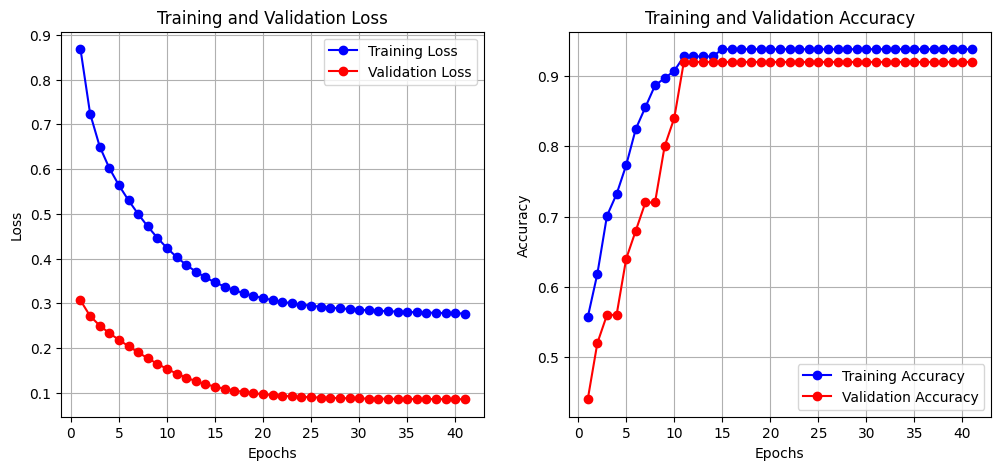

{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.1, 'alpha': 0.01, 'patience': 30}
Score: 0.9343333333333333


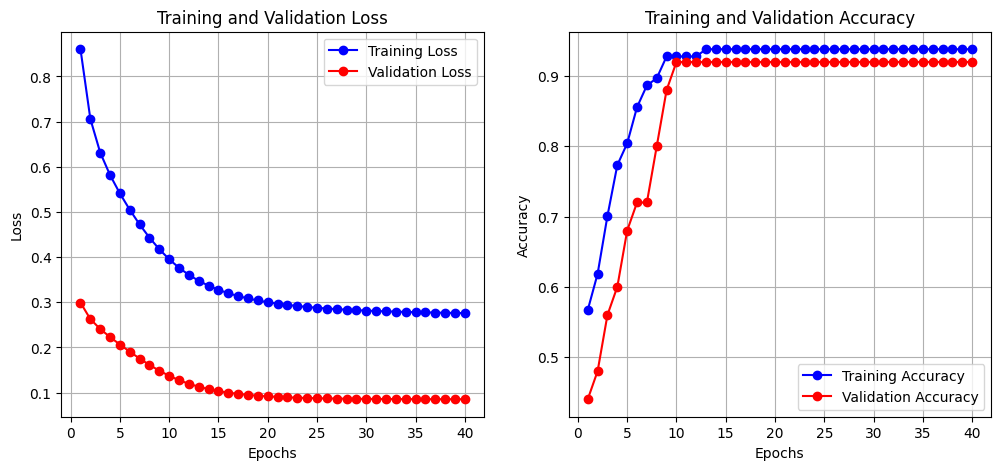

In [35]:
# Define the range of hyperparameters for the MONK 3 dataset
param_ranges_3 = {
    "learning_rate": (0.1, 0.1, 0.1),  # From 0.1 to 0.4 with a step of 0.1
    "epochs": (180, 180, 1),           # Fixed at 180 epochs
    "batch_size": (16, 16, 1),          # From 4 to 16 with a step of 6
    "hidden_size": (3, 3, 1),          # From 2 to 3 with a step of 1
    "hidden_layers": (1, 1, 1),        # Fixed at 1 hidden layer
    "momentum": (0.3, 0.3, 0.1),       # From 0.3 to 0.9 with a step of 0.1
    "regularization": (0.1, 0.1, 0.1), # From 0.1 to 0.4 with a step of 0.2
    "alpha": (0.01, 0.01, 0.01),       # Fixed at 0.01 alpha
    "patience": (30, 30, 1)            # Fixed at 30 epochs for early stopping patience
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk3 = generate_hyperparameter_combinations(param_ranges_3)

print("--------------------------------------------------MONK 3--------------------------------------------------")

# Perform greedy search to find the best hyperparameters for the MONK 3 dataset
best_scores[2], best_params_list[2], best_models[2], best_histories[2] = greed_search(
    X3_train_encoded, y3_train,  # Training data and labels for MONK 3
    'tanh', 'sgd', True,         # Activation function, optimizer, and regularization flag
    param_grid_monk3             # Hyperparameter grid
)

print("--------------------------------------------------Plots--------------------------------------------------")

# Plot the training history for each of the best models found
for i, (history, params, score) in enumerate(zip(best_histories[2], best_params_list[2], best_scores[2])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the validation score
    plot_training_history(history)  # Plot the training and validation loss and accuracy

In [36]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk1 = [best_params_list[0][0]]

scores_monk1, _ = double_k_fold_cross_validation(X1_train_encoded, y1_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = False, in_size = 6, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk1)

variance_1 = np.var(scores_monk1)
mean_monk1 = np.mean(scores_monk1)

print(f"Mean MONK 1: {mean_monk1}")
print(f"Variance MONK 1: {variance_1}")

Mean MONK 1: 0.9836666666666666
Variance MONK 1: 0.0004004444444444444


In [37]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk2 = [best_params_list[1][0]]

scores_monk2, _ = double_k_fold_cross_validation(X2_train_encoded, y2_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = False, in_size = 6, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk2)

variance_2 = np.var(scores_monk2)
mean_monk2 = np.mean(scores_monk2)

print(f"Mean MONK 2: {mean_monk2}")
print(f"Variance MONK 2: {variance_2}")

Mean MONK 2: 1.0
Variance MONK 2: 0.0


In [42]:
# Generate all combinations of hyperparameters based on the specified ranges
param_grid_final_monk3 = [best_params_list[2][0]]

scores_monk3, _ = double_k_fold_cross_validation(X3_train_encoded, y3_train, activ_type= 'tanh', optim_type = 'sgd', reg_flag = True, in_size = 6, outer_k = 5, inner_k = 5, param_grid=param_grid_final_monk3)

variance_3 = np.var(scores_monk3)
mean_monk3 = np.mean(scores_monk3)

print(f"Mean MONK 3: {mean_monk3}")
print(f"Variance MONK 3: {variance_3}")

Mean MONK 3: 0.9426666666666665
Variance MONK 3: 0.0030651111111111113


## Model assessment

In [39]:
test_acc_monk1 = accuracy_score(y1_test, best_models[0][0].predict(X1_test_encoded))
print(test_acc_monk1)

1.0


In [40]:
test_acc_monk2 = accuracy_score(y2_test, best_models[1][0].predict(X2_test_encoded))
print(test_acc_monk2)

1.0


In [41]:
test_acc_monk3 = accuracy_score(y3_test, best_models[2][0].predict(X3_test_encoded))
print(test_acc_monk3)

0.9722222222222222
